In [1]:
import pandas as pd
import urllib.request


data = pd.read_csv('../../../twitter/tweetdata/2018_complement1_tweet.csv', error_bad_lines=False)
data = data.append(pd.read_csv('../../../twitter/tweetdata/2018_complement1_tweet(e).csv', error_bad_lines=False))




In [4]:
text = data[['text']].astype(str)
text['text'] = text.apply(lambda row: row['text'].replace("/"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("-"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("—"," "), axis=1)
#text['main article'] = text.apply(lambda row: row['main article'].replace("",""), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("*"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("…"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("\\"," "), axis=1)



In [6]:
import nltk
text['text'] = text.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [8]:
# 소문자 적용 , - 문자 삭제
text['text'] = text['text'].apply(lambda x : [word.lower().replace("-","") for word in x])
# 공백문자 삭제
text['text'] = text['text'].apply(lambda x : [word for word in x if word])

In [9]:
from nltk.tag import pos_tag

text['pos tag'] = text.apply(lambda row: pos_tag(row['text']), axis=1)

In [10]:
# 불용어 품사 제거
text['text'] = text['pos tag'].apply(lambda x: [word[0] for word in x if word[1] not in ('CC','CD','DT','EX','IN','LS','MD','PRP','PRP$','RB','TO','UH','WDT','WP','WP$','WRB')])


In [11]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
text['text'] = text['text'].apply(lambda x: [word for word in x if word not in (stop)])

In [13]:
import csv
stopword_list =[]
f = open('../../../stopword/stop_en.txt', 'r')
reader = csv.reader(f)
for row in reader:
    #print(row[0])
    stopword_list.append(row[0])
    #pass
f.close()

text['text'] = text['text'].apply(lambda x: [word for word in x if word not in stopword_list])

In [14]:
import re
pattern=re.compile(r'\.')
print(pattern.search('abc.de'))

text['text'] = text['text'].apply(lambda x: [word for word in x if pattern.search(word)== None])

<re.Match object; span=(3, 4), match='.'>


In [15]:
number_pattern=re.compile(r'[0-9]\,[0-9]')
text['text'] = text['text'].apply(lambda x: [word for word in x if number_pattern.search(word)== None])

In [16]:
native_number_pattern=re.compile(r'[0-9]')
text['text'] = text['text'].apply(lambda x: [word for word in x if native_number_pattern.search(word)== None])

In [17]:
star_pattern=re.compile(r'[a-z0-9*]\*[a-z0-9*]')
text['text'] = text['text'].apply(lambda x: [word for word in x if star_pattern.search(word)== None])

In [18]:
from nltk.stem import WordNetLemmatizer
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x]) # 동사 
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='a') for word in x]) # 형용사
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='n') for word in x]) # 명사
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='r') for word in x]) # 부사
#print(text)

In [19]:
tokenized_doc = text['text'].apply(lambda x: [word for word in x if len(word) > 3])
#print(tokenized_doc)

In [20]:
article_contents = tokenized_doc.values.tolist()

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

In [22]:
tokenized_doc_tfidf = tokenized_doc.apply(lambda x : ' '.join(x))

In [23]:
article_contents_tfidf = tokenized_doc_tfidf.values.tolist()

In [24]:
vectorizer = TfidfVectorizer()
sp_matrix = vectorizer.fit_transform([ " ".join(article_contents_tfidf) ])

In [25]:
word2id = defaultdict(lambda: 0)

In [26]:
for idx, feature in enumerate(vectorizer.get_feature_names()):
    word2id[feature] = idx

In [27]:
tf_idf_result = []
token_list = []
for i, sent in enumerate([" ".join(article_contents_tfidf)]):
    for token in sent.split() :
        if token not in token_list :
            temp=[]
            temp.append(token)
            temp.append(sp_matrix[i, word2id[token]])
            token_list.append(token)
            tf_idf_result.append(temp)

In [28]:
len(tf_idf_result)

4037

In [29]:
tf_idf_value =[]
for tf_idf_element in tf_idf_result :
    tf_idf_value.append(tf_idf_element[1])
print(len(tf_idf_value))  ## tf-idf 값을 배열에 담음

4037


In [30]:
sentences = article_contents

In [31]:
from gensim.models import Word2Vec

In [32]:
model = Word2Vec(sentences, min_count=1)

In [33]:
len(model.wv.vocab)

4037

In [34]:
X = model[model.wv.vocab]

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [36]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=4
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
#kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.euclidean_distance, repeats=25)
#euclidean_distance
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
#print(X)
#print(assigned_clusters)

In [37]:
import pandas as pd
import numpy as np
temp_heder = ['raw_data','word','cluster','centroid','distance','tfidf','score','closer#']
temp_cluster_result = pd.DataFrame(columns=temp_heder)

In [38]:
temp_cluster_result['word'] = list(model.wv.vocab)

In [39]:
temp_cluster_result['cluster'] = assigned_clusters

In [40]:
temp_cluster_result['raw_data'] = X.tolist()

In [41]:
#temp_cluster_result['raw_data']
temp_cluster_result['centroid'] = temp_cluster_result['cluster'].apply(lambda x : kclusterer.means()[x])

In [42]:
from sklearn.metrics import pairwise_distances

In [43]:
cosine_centroid_list = []
for cosine_centroid in temp_cluster_result['centroid'] :
    cosine_centroid_list.append(cosine_centroid.tolist())

In [44]:
len(cosine_centroid_list)

4037

In [45]:
temp_distance = pairwise_distances(X,cosine_centroid_list, metric='cosine')

In [46]:
sum(temp_distance[3])

191.97010368981495

In [47]:
import scipy.spatial.distance as dist

In [48]:
dist.cosine(X[0],cosine_centroid_list[0])

0.04357189225277991

In [49]:
dist.euclidean(X[0],cosine_centroid_list[0])

0.029873859797729902

In [50]:
temp_cluster_result['distance'] = temp_cluster_result.apply(lambda x : dist.cosine(x.raw_data,x.centroid),axis=1)

In [51]:
temp_cluster_result['tfidf'] = tf_idf_value
temp_cluster_result['score'] = temp_cluster_result.apply(lambda x : x.distance + (1- x.tfidf),axis=1)
#temp_cluster_result

In [52]:
temp_cluster_result[temp_cluster_result['cluster']==0].sort_values(by=['score']).head(30)  # 비즈

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
4,"[0.17738677561283112, 0.4432727098464966, 0.35...",bitcoin,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000057,0.905223,0.094834,NaN
162,"[0.07804591953754425, 0.20522655546665192, 0.1...",ethereum,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000305,0.131797,0.868508,NaN
132,"[0.0945608988404274, 0.2304181158542633, 0.189...",http,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000206,0.119322,0.880884,NaN
125,"[0.08366981148719788, 0.20840871334075928, 0.1...",crypto,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000338,0.080814,0.919524,NaN
209,"[0.06532839685678482, 0.16514639556407928, 0.1...",trade,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000412,0.068339,0.932072,NaN
117,"[0.07221654057502747, 0.18525300920009613, 0.1...",people,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000382,0.067797,0.932586,NaN
190,"[0.06569479405879974, 0.18259769678115845, 0.1...",think,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000350,0.067254,0.933095,NaN
590,"[0.0691443383693695, 0.19062285125255585, 0.14...",time,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000332,0.061831,0.938502,NaN
121,"[0.05971570685505867, 0.16787593066692352, 0.1...",make,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000460,0.061831,0.938629,NaN
95,"[0.08078716695308685, 0.19794060289859772, 0.1...",market,0,"[0.0059710066, 0.01572384, 0.012550983, -0.001...",0.000367,0.060746,0.939621,NaN


In [53]:
temp_cluster_result[temp_cluster_result['cluster']==1].sort_values(by=['score']).head(30)  # 거래

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
3026,"[0.004803790710866451, 0.0038081391248852015, ...",antimatter,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.150154,0.001627,1.148527,NaN
3099,"[0.002980730962008238, 0.0023988522589206696, ...",immediate,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.185607,0.001085,1.184522,NaN
3207,"[0.0007994244806468487, 0.002107149688526988, ...",pronounce,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.192117,0.000542,1.191574,NaN
2953,"[-0.0006911465898156166, 0.005010564345866442,...",browser,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.239562,0.001085,1.238477,NaN
1742,"[0.0066630644723773, 0.0007985787815414369, 0....",witnessinvalidnoncesize,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.241312,0.000542,1.240769,NaN
1077,"[0.0016679578693583608, 0.004283641930669546, ...",rank,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.247668,0.001085,1.246583,NaN
2511,"[0.003544432809576392, 0.0006119143217802048, ...",onemorepeter,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.251910,0.000542,1.251367,NaN
2029,"[0.0036853845231235027, 0.0010514744790270925,...",ticker,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.266223,0.001085,1.265138,NaN
2455,"[0.001385537558235228, 0.006937784142792225, 0...",embursment,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.271910,0.000542,1.271368,NaN
2311,"[0.0037141339853405952, 0.004297792911529541, ...",collude,1,"[0.0007320582, 0.0017898227, 0.0024314749, -0....",0.290517,0.000542,1.289975,NaN


In [54]:
temp_cluster_result[temp_cluster_result['cluster']==2].sort_values(by=['score']).head(40)   # 협업

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
225,"[0.007446701172739267, 0.01320036593824625, 0....",maximalism,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.091678,0.002169,1.089508,NaN
403,"[0.004067803733050823, 0.004937260411679745, 0...",bitcoincom,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.123113,0.001627,1.121486,NaN
2003,"[0.0032673231326043606, 0.011862220242619514, ...",owner,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.125652,0.001085,1.124567,NaN
1781,"[0.002222901675850153, 0.010178057476878166, 0...",moment,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.135788,0.001627,1.134161,NaN
1613,"[0.00691124377772212, 0.001719038118608296, 0....",maximum,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.179705,0.000542,1.179163,NaN
732,"[0.0036672165151685476, 0.00399357033893466, 0...",yellen,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.190517,0.001627,1.188890,NaN
3341,"[-0.0020423720125108957, 0.00662293191999197, ...",cryptographer,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.190667,0.000542,1.190125,NaN
3752,"[0.004532995168119669, 0.00607013376429677, 0....",disappearance,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.190895,0.000542,1.190352,NaN
2399,"[0.000989748165011406, 0.005239055026322603, 0...",milestone,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.208071,0.001085,1.206986,NaN
3596,"[0.0010212177876383066, 0.006379135884344578, ...",onion,2,"[0.0016892231, 0.0025634733, 0.0013901652, 3.3...",0.209482,0.000542,1.208940,NaN


In [55]:
temp_cluster_result[temp_cluster_result['cluster']==3].sort_values(by=['score']).head(20)  # 거래소

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
3776,"[-0.002435378497466445, 0.0015026674373075366,...",lememori,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.674297,0.000542,1.673754,NaN
2232,"[-0.001191869843751192, -0.006211291067302227,...",supreme,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.680029,0.000542,1.679486,NaN
1526,"[-0.004933696705847979, -0.0003501681494526565...",liberty,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.684993,0.000542,1.684451,NaN
1340,"[-0.003203354310244322, -0.003230242058634758,...",familiar,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.694124,0.000542,1.693582,NaN
1041,"[-0.0010653615463525057, -0.003819702193140983...",starter,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.717067,0.000542,1.716524,NaN
3681,"[0.004017695318907499, 0.0027606624644249678, ...",askblockchain,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.719870,0.000542,1.719328,NaN
3179,"[0.00424193823710084, -0.004203808959573507, -...",journalism,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.720852,0.000542,1.720310,NaN
3886,"[0.0021661301143467426, -0.003537462092936039,...",june,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.729138,0.000542,1.728595,NaN
3896,"[-0.0006463528261519969, 0.004770690109580755,...",blossom,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.730346,0.000542,1.729803,NaN
1885,"[0.003663839539512992, 8.400275692110881e-05, ...",smooth,3,"[0.00011451896, -0.00043245446, -8.928925e-05,...",0.736151,0.000542,1.735608,NaN


In [56]:
y_km = temp_cluster_result['cluster'].values

In [57]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

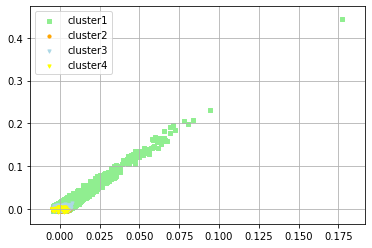

In [58]:
plt.scatter(X[y_km==0,0],X[y_km==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[y_km==1,0],X[y_km==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[y_km==2,0],X[y_km==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[y_km==3,0],X[y_km==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [59]:
len(temp_cluster_result[temp_cluster_result['cluster']==0]) # 인플

3058

In [60]:
len(temp_cluster_result[temp_cluster_result['cluster']==1]) # 비즈 

383

In [61]:
len(temp_cluster_result[temp_cluster_result['cluster']==2]) # 협업

533

In [62]:
len(temp_cluster_result[temp_cluster_result['cluster']==3]) # 거래소

63

In [63]:
# X[:,1]
from sklearn.cluster import AgglomerativeClustering
import numpy as np

agg = AgglomerativeClustering(n_clusters=4, linkage ="average", affinity="cosine")

assign = agg.fit_predict(X)
# assign = agg.fit(X)

In [64]:
len(assign)

4037

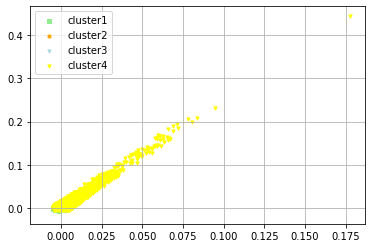

In [65]:
plt.scatter(X[assign==0,0],X[assign==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign==1,0],X[assign==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign==2,0],X[assign==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign==3,0],X[assign==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [66]:
assign

array([3, 3, 3, ..., 3, 3, 3])

In [67]:
from scipy.cluster.hierarchy import dendrogram

In [68]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

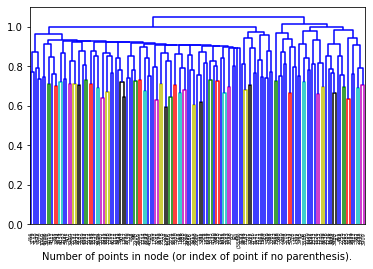

In [69]:

model1 = AgglomerativeClustering(linkage ="average", affinity="cosine", distance_threshold=0, n_clusters=None)

model1.fit(X)

plot_dendrogram(model1, truncate_mode='level', p=20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [70]:
temp_cluster_result0 = pd.DataFrame(columns=temp_heder)

In [71]:
temp_cluster_result0['word'] = list(model.wv.vocab)

In [72]:
temp_cluster_result0['cluster'] = assign

In [73]:
temp_cluster_result0['raw_data'] = X.tolist()

In [74]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
clf = NearestCentroid()
clf.fit(X, assign)

temp_cluster_result0['centroid'] = temp_cluster_result0['cluster'].apply(lambda x : clf.centroids_[x])

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [75]:
cosine_centroid_list0 = []
for cosine_centroid in temp_cluster_result0['centroid'] :
    cosine_centroid_list0.append(cosine_centroid.tolist())

In [76]:
temp_distance0 = pairwise_distances(X,cosine_centroid_list0, metric='cosine')

In [77]:
temp_cluster_result0['distance'] = temp_cluster_result0.apply(lambda x : dist.cosine(x.raw_data,x.centroid),axis=1)

In [78]:
temp_cluster_result0['tfidf'] = tf_idf_value
temp_cluster_result0['score'] = temp_cluster_result0.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [79]:
temp_cluster_result0[temp_cluster_result0['cluster']==0].sort_values(by=['score']).head(20)  # 긍정, 이슈 , 

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
1340,"[-0.003203354310244322, -0.003230242058634758,...",familiar,0,"[-0.0010965395485982299, -0.000237662679865024...",0.578517,0.000542,1.577974,NaN
2758,"[-0.0028136803302913904, -0.000656417745631188...",btcupd,0,"[-0.0010965395485982299, -0.000237662679865024...",0.602560,0.000542,1.602017,NaN
3961,"[0.001285998965613544, 0.0011517000384628773, ...",slideslive,0,"[-0.0010965395485982299, -0.000237662679865024...",0.612272,0.000542,1.611729,NaN
1526,"[-0.004933696705847979, -0.0003501681494526565...",liberty,0,"[-0.0010965395485982299, -0.000237662679865024...",0.624101,0.000542,1.623559,NaN
2232,"[-0.001191869843751192, -0.006211291067302227,...",supreme,0,"[-0.0010965395485982299, -0.000237662679865024...",0.628720,0.000542,1.628178,NaN
1236,"[-0.0006165200611576438, 0.004085056949406862,...",unkind,0,"[-0.0010965395485982299, -0.000237662679865024...",0.632384,0.000542,1.631842,NaN
1402,"[-0.003755919635295868, 0.0004472277651075274,...",loser,0,"[-0.0010965395485982299, -0.000237662679865024...",0.650600,0.000542,1.650058,NaN
3681,"[0.004017695318907499, 0.0027606624644249678, ...",askblockchain,0,"[-0.0010965395485982299, -0.000237662679865024...",0.656518,0.000542,1.655976,NaN
722,"[-0.0020655335392802954, -0.003176982747390866...",magazine,0,"[-0.0010965395485982299, -0.000237662679865024...",0.659876,0.000542,1.659333,NaN
2829,"[0.002357862191274762, 0.0029114182107150555, ...",mane,0,"[-0.0010965395485982299, -0.000237662679865024...",0.691988,0.000542,1.691446,NaN


In [80]:
temp_cluster_result0[temp_cluster_result0['cluster']==1].sort_values(by=['score']).head(20)  # 이슈 , 

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
1569,"[-0.0005041342228651047, 0.004283352289348841,...",beirut,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.562685,0.000542,1.562142,NaN
3227,"[-0.0012422989821061492, 0.00111809850204736, ...",permanent,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.565885,0.000542,1.565342,NaN
3061,"[-0.002201708732172847, 0.0024238675832748413,...",paciprosa,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.595072,0.000542,1.594530,NaN
2766,"[0.002235730644315481, 0.0025782317388802767, ...",hybornation,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.607769,0.000542,1.607226,NaN
2095,"[0.001371787628158927, -0.000987359555438161, ...",undeniable,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.615197,0.000542,1.614654,NaN
2143,"[0.003782147541642189, 0.002973038936033845, -...",lynch,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.619674,0.000542,1.619132,NaN
510,"[-0.004918503575026989, 0.00026770937256515026...",bulletproof,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.626292,0.000542,1.625749,NaN
368,"[-0.003392438869923353, -0.002052565338090062,...",asymmetric,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.639187,0.000542,1.638645,NaN
3141,"[0.002895976649597287, 0.0032494973856955767, ...",asilayhodling,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.654847,0.000542,1.654305,NaN
3489,"[0.0018367597367614508, 0.002367056906223297, ...",tweetstorms,1,"[0.0002178406430175528, 0.001454282901249826, ...",0.673481,0.001085,1.672396,NaN


In [81]:
temp_cluster_result0[temp_cluster_result0['cluster']==2].sort_values(by=['score']).head(20)  # 기타

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
3776,"[-0.002435378497466445, 0.0015026674373075366,...",lememori,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.488219,0.000542,1.487676,NaN
720,"[0.0006796732195653021, 0.0023464043624699116,...",ross,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.532845,0.000542,1.532303,NaN
2443,"[-0.0008958873222582042, 0.0018687222618609667...",ldvqtwjvmre,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.538563,0.000542,1.538021,NaN
3772,"[-0.004419175907969475, -0.0029892846941947937...",gamaroff,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.548619,0.000542,1.548076,NaN
2200,"[0.0011069413740187883, -0.0002252311096526682...",lean,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.554528,0.000542,1.553986,NaN
1662,"[-0.0034447594080120325, -0.002125214785337448...",dilute,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.582909,0.000542,1.582367,NaN
640,"[-0.0025600118096917868, -0.002726604929193854...",coingate,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.585368,0.000542,1.584826,NaN
474,"[0.002578838262706995, -0.006074190139770508, ...",tutorial,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.600226,0.000542,1.599684,NaN
1451,"[-0.0005319159245118499, 0.005679895635694265,...",reconsider,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.685820,0.000542,1.685277,NaN
2368,"[-0.00046429724898189306, 0.002411954570561647...",tradercobb,2,"[-0.0010385973146185279, -3.308815576019697e-0...",0.727631,0.000542,1.727088,NaN


In [82]:
temp_cluster_result0[temp_cluster_result0['cluster']==3].sort_values(by=['score']).head(20)  #  거래, 기술

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
4,"[0.17738677561283112, 0.4432727098464966, 0.35...",bitcoin,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000054,0.905223,0.094831,NaN
162,"[0.07804591953754425, 0.20522655546665192, 0.1...",ethereum,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000268,0.131797,0.868471,NaN
132,"[0.0945608988404274, 0.2304181158542633, 0.189...",http,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000183,0.119322,0.880860,NaN
125,"[0.08366981148719788, 0.20840871334075928, 0.1...",crypto,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000308,0.080814,0.919494,NaN
209,"[0.06532839685678482, 0.16514639556407928, 0.1...",trade,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000385,0.068339,0.932046,NaN
117,"[0.07221654057502747, 0.18525300920009613, 0.1...",people,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000354,0.067797,0.932557,NaN
190,"[0.06569479405879974, 0.18259769678115845, 0.1...",think,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000351,0.067254,0.933096,NaN
590,"[0.0691443383693695, 0.19062285125255585, 0.14...",time,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000325,0.061831,0.938494,NaN
121,"[0.05971570685505867, 0.16787593066692352, 0.1...",make,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000458,0.061831,0.938627,NaN
95,"[0.08078716695308685, 0.19794060289859772, 0.1...",market,3,"[0.004891168791800737, 0.012574028223752975, 0...",0.000361,0.060746,0.939616,NaN


In [89]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==0]) # 혼란

29

In [90]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==1]) # 이슈 

14

In [91]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==2]) # 기타 

10

In [92]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==3]) # 거래, 기술 

3984

In [93]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(X, assign, metric='cosine')

In [94]:
silhouette_score

0.47257006

In [95]:
"""
temp_cluster_result['category'] = 1 # 1 영문뉴스, 2 국문뉴스 , 3 twitter
temp_cluster_result.loc[temp_cluster_result['cluster']==0,'label'] = 7 # 비즈
temp_cluster_result.loc[temp_cluster_result['cluster']==1,'label'] = 12 #  가격, 거래소, 돈
temp_cluster_result.loc[temp_cluster_result['cluster']==2,'label'] = 9 # 기술발전
temp_cluster_result.loc[temp_cluster_result['cluster']==3,'label'] = 7 # 비즈
"""

"\ntemp_cluster_result['category'] = 1 # 1 영문뉴스, 2 국문뉴스 , 3 twitter\ntemp_cluster_result.loc[temp_cluster_result['cluster']==0,'label'] = 7 # 비즈\ntemp_cluster_result.loc[temp_cluster_result['cluster']==1,'label'] = 12 #  가격, 거래소, 돈\ntemp_cluster_result.loc[temp_cluster_result['cluster']==2,'label'] = 9 # 기술발전\ntemp_cluster_result.loc[temp_cluster_result['cluster']==3,'label'] = 7 # 비즈\n"

In [96]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)

KMeans(n_clusters=4)

In [97]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [98]:
kmeans.inertia_

13.604052543640137

In [99]:
print ("Cluster id labels for inputted data")
print (labels)

Cluster id labels for inputted data
[0 1 2 ... 1 1 1]


In [100]:
cluster_values= list(model.wv.vocab)

In [101]:
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))

Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-13.604052543640137


In [102]:
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

In [103]:
print ("Silhouette_score: ")
print (silhouette_score)

Silhouette_score: 
0.5758781


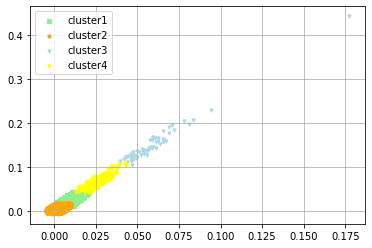

In [104]:
kmeans_label = kmeans.labels_

plt.scatter(X[kmeans_label==0,0],X[kmeans_label==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[kmeans_label==1,0],X[kmeans_label==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[kmeans_label==2,0],X[kmeans_label==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[kmeans_label==3,0],X[kmeans_label==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[kmeans_label==4,0],X[kmeans_label==4,1],c='red',marker='v',s=10 , label='cluster5')

plt.legend()
plt.grid(True)
plt.show()

In [105]:
temp_cluster_result1 = pd.DataFrame(columns=temp_heder)
temp_cluster_result1['word'] = list(model.wv.vocab)
temp_cluster_result1['cluster'] = kmeans_label

In [106]:
#temp_cluster_result1[temp_cluster_result1['cluster']==0].head(30) #시도 및 혼돈  # 혼란 부정적 
temp_cluster_result1['raw_data'] = X.tolist()

In [107]:
temp_cluster_result1['centroid'] = temp_cluster_result1['cluster'].apply(lambda x : centroids[x])

In [108]:
euclidean_centroid_list = []
for euclidean_centroid in temp_cluster_result1['centroid'] :
    euclidean_centroid_list.append(euclidean_centroid.tolist())

In [109]:
temp_distance1 = pairwise_distances(X,euclidean_centroid_list, metric='euclidean')

In [110]:
import scipy.spatial.distance as dist

In [111]:
temp_cluster_result1['distance'] = temp_cluster_result1.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

In [112]:
temp_cluster_result1['tfidf'] = tf_idf_value
temp_cluster_result1['score'] = temp_cluster_result1.apply(lambda x : x.distance + (1- x.tfidf),axis=1)
#temp_cluster_result1

In [113]:
temp_cluster_result1[temp_cluster_result1['cluster']==0].sort_values('score',ascending=False).nsmallest(30,'score') # 부정

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
175,"[0.0076290639117360115, 0.023975670337677002, ...",ecosystem,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.028277,0.007593,1.020684,NaN
2403,"[0.007645458448678255, 0.025363901630043983, 0...",leahwald,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.027797,0.007051,1.020746,NaN
1968,"[0.010180472396314144, 0.022902417927980423, 0...",presentation,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.027041,0.005966,1.021074,NaN
851,"[0.011915863491594791, 0.02802949957549572, 0....",decade,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.027350,0.005424,1.021926,NaN
504,"[0.01302282139658928, 0.02333025261759758, 0.0...",release,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.030372,0.008136,1.022237,NaN
845,"[0.004186997190117836, 0.026813795790076256, 0...",area,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.026659,0.004339,1.022320,NaN
227,"[0.006733791437000036, 0.027173640206456184, 0...",platform,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.028304,0.005966,1.022338,NaN
1348,"[0.01231470052152872, 0.025922279804944992, 0....",self,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.028494,0.005966,1.022528,NaN
1755,"[0.006753150839358568, 0.026749731972813606, 0...",decide,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.026946,0.004339,1.022607,NaN
564,"[0.005320629104971886, 0.027641626074910164, 0...",matter,0,"[0.009393852, 0.024536854, 0.019552652, -0.002...",0.029282,0.006508,1.022773,NaN


In [114]:
temp_cluster_result1[temp_cluster_result1['cluster']==1].sort_values('score',ascending=False).nsmallest(40,'score') # 긍정

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
3863,"[0.0007639508694410324, 0.004328528884798288, ...",spec,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.025235,0.001627,1.023608,NaN
711,"[0.004574587568640709, 3.841723082587123e-05, ...",stand,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.025473,0.001627,1.023846,NaN
3534,"[0.0033331885933876038, 0.004567363299429417, ...",fundamentalist,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.024689,0.000542,1.024147,NaN
3510,"[0.00024343724362552166, 0.0050053708255290985...",dilemma,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.025994,0.001627,1.024367,NaN
3391,"[0.002857975894585252, 0.0003938766894862056, ...",nfts,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.026835,0.002169,1.024665,NaN
957,"[0.0025150999426841736, 0.0029814273584634066,...",loyalty,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.025878,0.001085,1.024793,NaN
2938,"[0.002349347108975053, 0.005634337197989225, 0...",blockhashes,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.025574,0.000542,1.025031,NaN
3505,"[0.0022753512021154165, 0.006337577477097511, ...",desk,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.025640,0.000542,1.025098,NaN
2698,"[0.00495364423841238, 0.005741479340940714, 0....",frustrate,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.026775,0.001627,1.025148,NaN
2963,"[0.00575933326035738, 0.0009298825170844793, 0...",partial,1,"[0.001829851, 0.0046614553, 0.0037541706, -0.0...",0.026278,0.001085,1.025193,NaN


In [115]:
temp_cluster_result1[temp_cluster_result1['cluster']==2].sort_values('score',ascending=False).nsmallest(30,'score')  # 제도,한계

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
389,"[0.06145666539669037, 0.14354631304740906, 0.1...",protocol,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.039566,0.056407,0.983159,NaN
104,"[0.0635482519865036, 0.15311530232429504, 0.12...",chain,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.027712,0.041220,0.986491,NaN
138,"[0.06093957647681236, 0.1574053168296814, 0.12...",price,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.031063,0.043932,0.987131,NaN
15,"[0.058307673782110214, 0.1451287418603897, 0.1...",fork,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.044824,0.040136,1.004688,NaN
395,"[0.062427159398794174, 0.1601283848285675, 0.1...",block,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.055513,0.050441,1.005072,NaN
347,"[0.058975521475076675, 0.14402540028095245, 0....",look,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.042055,0.033627,1.008428,NaN
1084,"[0.057586781680583954, 0.16279900074005127, 0....",asset,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.055199,0.045559,1.009639,NaN
644,"[0.058966293931007385, 0.16064752638339996, 0....",gold,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.054031,0.042848,1.011184,NaN
60,"[0.0530177503824234, 0.14176492393016815, 0.11...",transaction,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.043535,0.030373,1.013162,NaN
80,"[0.06565015763044357, 0.15801174938678741, 0.1...",good,2,"[0.05903911, 0.15209718, 0.12053284, -0.015480...",0.061353,0.047187,1.014166,NaN


In [116]:
temp_cluster_result1[temp_cluster_result1['cluster']==3].sort_values('score',ascending=False).nsmallest(30,'score') #  기타

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
479,"[0.02882692962884903, 0.061072465032339096, 0....",learn,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.028552,0.016814,1.011738,NaN
902,"[0.019898081198334694, 0.06100761145353317, 0....",secure,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.028920,0.016271,1.012649,NaN
680,"[0.028613442555069923, 0.07025520503520966, 0....",hold,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.029520,0.016814,1.012706,NaN
142,"[0.02085510641336441, 0.0653626024723053, 0.05...",help,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.027899,0.014102,1.013798,NaN
268,"[0.020209498703479767, 0.06629634648561478, 0....",major,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.027286,0.013017,1.014269,NaN
1068,"[0.02670234814286232, 0.06909099966287613, 0.0...",argument,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.027892,0.013559,1.014333,NaN
636,"[0.022219346836209297, 0.06613580882549286, 0....",anything,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.029533,0.014102,1.015432,NaN
110,"[0.022256311029195786, 0.05980317294597626, 0....",token,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.029819,0.014102,1.015717,NaN
313,"[0.02188236638903618, 0.06347063928842545, 0.0...",system,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.030113,0.013559,1.016554,NaN
497,"[0.024755805730819702, 0.059141192585229874, 0...",open,3,"[0.025242088, 0.064955585, 0.05192561, -0.0065...",0.030455,0.013559,1.016896,NaN


In [117]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==0]) # 부정

568

In [118]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==1]) # 긍정

3224

In [119]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==2]) # 제도,한계

60

In [120]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==3]) # 기타

185

In [121]:
agg1 = AgglomerativeClustering(n_clusters=4, linkage ="average", affinity="euclidean")

assign1 = agg1.fit_predict(X)

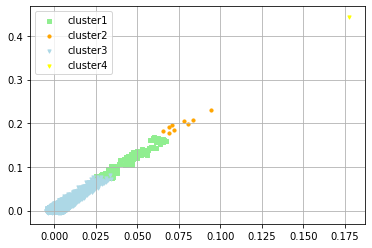

In [122]:
plt.scatter(X[assign1==0,0],X[assign1==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign1==1,0],X[assign1==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign1==2,0],X[assign1==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign1==3,0],X[assign1==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [123]:
temp_cluster_result2 = pd.DataFrame(columns=temp_heder)
temp_cluster_result2['word'] = list(model.wv.vocab)
temp_cluster_result2['cluster'] = assign1
temp_cluster_result2['raw_data'] = X.tolist()
clf1 = NearestCentroid()
clf1.fit(X, assign1)

NearestCentroid()

In [124]:
temp_cluster_result2['centroid'] = temp_cluster_result2['cluster'].apply(lambda x : clf1.centroids_[x])

In [125]:
euclidean_centroid_list2 = []
for euclidean_centroid in temp_cluster_result2['centroid'] :
    euclidean_centroid_list2.append(euclidean_centroid.tolist())

In [126]:

temp_distance2 = pairwise_distances(X,euclidean_centroid_list2, metric='euclidean')

In [127]:
temp_cluster_result2['distance'] = temp_cluster_result2.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

In [128]:
temp_cluster_result2['tfidf'] = tf_idf_value
temp_cluster_result2['score'] = temp_cluster_result2.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [129]:
temp_cluster_result2[temp_cluster_result2['cluster']==0].sort_values(by=['score']).head(20) #  채굴, 투자 

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
20,"[0.03961515799164772, 0.11482740938663483, 0.0...",short,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.035547,0.028746,1.006802,NaN
248,"[0.04201973229646683, 0.11736174672842026, 0.0...",miner,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.038170,0.029288,1.008882,NaN
750,"[0.046505749225616455, 0.11392638832330704, 0....",mean,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.032286,0.023322,1.008964,NaN
54,"[0.04374970868229866, 0.11148498207330704, 0.0...",cash,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.041743,0.027119,1.014624,NaN
1149,"[0.04698825255036354, 0.10498419404029846, 0.0...",great,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.040303,0.024949,1.015354,NaN
475,"[0.04637599363923073, 0.12063275277614594, 0.0...",core,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.050503,0.029831,1.020672,NaN
136,"[0.04892304539680481, 0.124636210501194, 0.090...",next,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.054514,0.026576,1.027937,NaN
19,"[0.043728530406951904, 0.10419365763664246, 0....",start,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.055151,0.021695,1.033456,NaN
350,"[0.04288586229085922, 0.10962314903736115, 0.0...",scale,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.058299,0.023864,1.034435,NaN
1312,"[0.04987208545207977, 0.1209932342171669, 0.10...",user,0,"[0.043894171714782715, 0.11358732730150223, 0....",0.061810,0.024407,1.037403,NaN


In [130]:
temp_cluster_result2[temp_cluster_result2['cluster']==1].sort_values(by=['score']).head(20) #  거래

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
162,"[0.07804591953754425, 0.20522655546665192, 0.1...",ethereum,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.049077,0.131797,0.917280,NaN
95,"[0.08078716695308685, 0.19794060289859772, 0.1...",market,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.038724,0.060746,0.977978,NaN
2,"[0.07102836668491364, 0.1954161673784256, 0.14...",year,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.039244,0.055865,0.983379,NaN
125,"[0.08366981148719788, 0.20840871334075928, 0.1...",crypto,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.077489,0.080814,0.996675,NaN
590,"[0.0691443383693695, 0.19062285125255585, 0.14...",time,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.060548,0.061831,0.998718,NaN
117,"[0.07221654057502747, 0.18525300920009613, 0.1...",people,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.089356,0.067797,1.021559,NaN
190,"[0.06569479405879974, 0.18259769678115845, 0.1...",think,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.110486,0.067254,1.043231,NaN
114,"[0.06910380721092224, 0.17732001841068268, 0.1...",need,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.108167,0.042848,1.065319,NaN
132,"[0.0945608988404274, 0.2304181158542633, 0.189...",http,1,"[0.07602795958518982, 0.19702261686325073, 0.1...",0.242679,0.119322,1.123357,NaN


In [131]:
temp_cluster_result2[temp_cluster_result2['cluster']==2].sort_values(by=['score']).head(20) # 기술, 이슈 

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
916,"[0.004029537551105022, 0.010540014132857323, 0...",nonsense,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.026474,0.003254,1.023220,NaN
547,"[0.00685040233656764, 0.0054452791810035706, 0...",sidechains,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.026568,0.003254,1.023313,NaN
2034,"[-0.00016465129738207906, 0.008151721209287643...",quick,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.026996,0.002712,1.024284,NaN
513,"[0.008121224120259285, 0.008404106833040714, 0...",wrap,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.026243,0.001627,1.024615,NaN
515,"[0.004122355952858925, 0.01357263419777155, 0....",cool,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.027419,0.002712,1.024707,NaN
1527,"[0.008537217043340206, 0.009248574264347553, 0...",speaker,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.027992,0.003254,1.024738,NaN
1729,"[0.00811808928847313, 0.007052944973111153, 0....",chernobyl,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.027063,0.002169,1.024893,NaN
3479,"[0.004876602441072464, 0.01431853324174881, 0....",determine,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.026611,0.001627,1.024984,NaN
1248,"[0.003201995976269245, 0.013050731271505356, 0...",sanction,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.027167,0.002169,1.024997,NaN
2775,"[0.006360488478094339, 0.007081047166138887, 0...",friendly,2,"[0.003645767457783222, 0.009382601827383041, 0...",0.026677,0.001627,1.025050,NaN


In [132]:
temp_cluster_result2[temp_cluster_result2['cluster']==3].sort_values(by=['score']).head(20) # 암호화폐 

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
4,"[0.17738677561283112, 0.4432727098464966, 0.35...",bitcoin,3,"[0.17738677561283112, 0.4432727098464966, 0.35...",0.0,0.905223,0.094777,NaN


In [133]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==0]) # 채굴, 투자 

97

In [134]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==1]) # 거래

9

In [135]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==2]) # 기술, 이슈

3930

In [136]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==3]) # 암호화폐 

1

In [137]:
silhouette_score1 = metrics.silhouette_score(X, assign1, metric='euclidean')

In [138]:
silhouette_score1

0.84039557

In [ ]:
agg2 = AgglomerativeClustering(n_clusters=4, linkage ="ward", affinity="euclidean")

assign2 = agg2.fit_predict(X)

In [ ]:
plt.scatter(X[assign2==0,0],X[assign2==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign2==1,0],X[assign2==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign2==2,0],X[assign2==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign2==3,0],X[assign2==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
temp_cluster_result3 = pd.DataFrame(columns=temp_heder)
temp_cluster_result3['word'] = list(model.wv.vocab)
temp_cluster_result3['cluster'] = assign2
temp_cluster_result3['raw_data'] = X.tolist()
clf2 = NearestCentroid()
clf2.fit(X, assign2)

In [ ]:
temp_cluster_result3['centroid'] = temp_cluster_result3['cluster'].apply(lambda x : clf2.centroids_[x])

In [ ]:
euclidean_centroid_list3 = []
for euclidean_centroid in temp_cluster_result3['centroid'] :
    euclidean_centroid_list3.append(euclidean_centroid.tolist())

In [ ]:
temp_distance3 = pairwise_distances(X,euclidean_centroid_list3, metric='euclidean')

In [ ]:
temp_cluster_result3['distance'] = temp_cluster_result3.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

temp_cluster_result3['tfidf'] = tf_idf_value
temp_cluster_result3['score'] = temp_cluster_result3.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==0].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==1].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==2].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==3].sort_values(by=['score']).head(20)

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==0])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==1])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==2])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==3])

In [ ]:
silhouette_score3 = metrics.silhouette_score(X, assign2, metric='euclidean')

In [ ]:
silhouette_score3

In [ ]:

"""
temp_cluster_result1['result'] = 1 # 1 상승 2 하락 3 보합
temp_cluster_result['result'] = 1
temp_cluster_result1['Silhouette'] = 0.7476496# 1 상승 2 하락 3 보합
temp_cluster_result['Silhouette'] = 0.7476496
 """

In [ ]:
#temp_cluster_result1.to_csv("../cluster/en_news/2017_up2/en_news_2017_up2_euclidean.csv")
#temp_cluster_result.to_csv("../cluster/en_news/2017_up2/en_news_2017_up2_cosine.csv")